In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

In [2]:
good_maps = [
    'data/13_102.5_104.5_0.1.npy',
    'data/15_216_220_0.2.npy',
    'data/15_314.5_318.5_0.2.npy',
    'data/13_370_400_0.5.npy',
    'data/13_490_496_0.2.npy',
    'data/15_646_650_0.2.npy',
    'data/15_710_718_0.2.npy',
    'data/15_900_905_0.2.npy',
    'data/15_1138_1158_0.3.npy'
]
eigenmodes = [
    [1, 1], #102
    [[1, 2], [2, 1]], #216
    [2, 2], #314
    [1, 3], #370
    [[2, 3], [3, 2]], #490
    [3, 3], #646
    [[2, 4], [4, 2]],#710 
    [[1, 5], [5, 1]],#900
    [[3, 5], [5, 3]]#1138
]

Here are all the eigenmode functions:

In [3]:
eigenmode_function = []
eigenmode_function.append(lambda x: 0.75*(np.cos(x)+.333*np.cos(3*x)))
eigenmode_function.append(lambda x: 0.667*(np.sin(2*x)+.5*np.sin(4*x)))
eigenmode_function.append(lambda x: 0.625*(np.cos(3*x)+.6*np.cos(5*x)))
eigenmode_function.append(lambda x: 0.6*(np.sin(4*x)+0.667*np.sin(6*x)))
eigenmode_function.append(lambda x: 0.583*(np.cos(5*x)+.71429*np.cos(7*x)))

Let's generate a data domain for this:

In [11]:
ADC_to_voltage = 1./95.6
vmax = 3.2*ADC_to_voltage
mm_per_gridpoint = 16.485
steps_to_edge = 7950. #\pm 50
steps_taken_max = 5000. #(some data has 5000)
phase_at_edge = 1.0
phase_at_max = phase_at_edge*steps_taken_max/steps_to_edge
x_domain_full = np.linspace(-phase_at_edge, phase_at_edge, 1000)
y_domain_full = np.copy(x_domain_full)

Now, let's generate the appropriate amplitudes:

In [36]:
eigenmode_amplitudes = np.array(
    [[np.dot(eigenmode_function[i](x_domain_full)[:, None],
       eigenmode_function[j](y_domain_full)[None])
       for i in range(5)] for j in range(5)])

Let's plot one of these, say the 1-1 mode, as a sanity check:

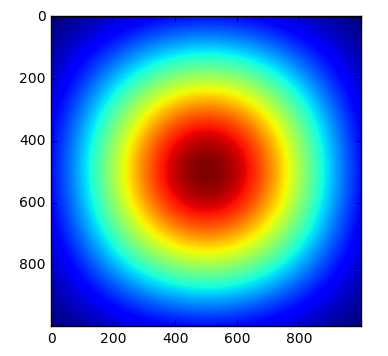

In [52]:
plt.imshow(np.dot(eigenmode_function[0](x_domain_full)[:, None],
                   eigenmode_function[0](y_domain_full)[None]))

Now let's plot all of our theory data:

[1, 1]


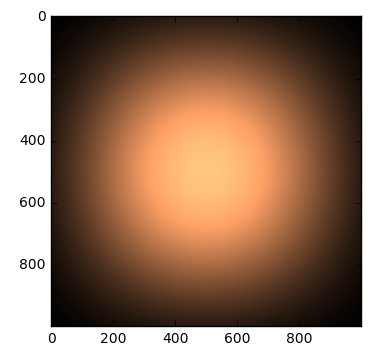

[[1, 2], [2, 1]]


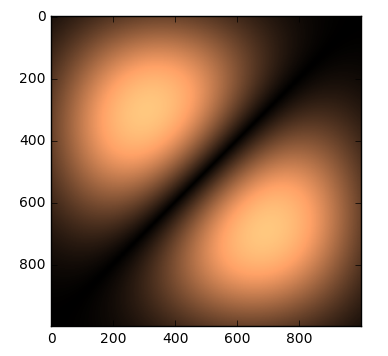

[2, 2]


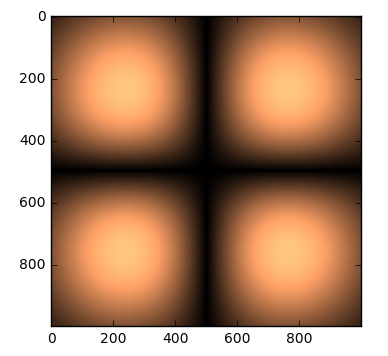

[1, 3]


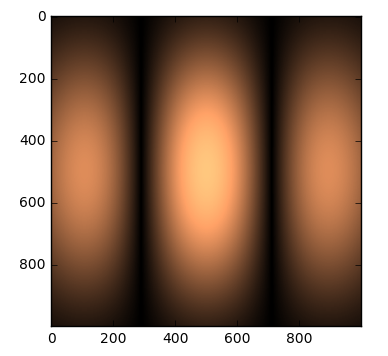

[[2, 3], [3, 2]]


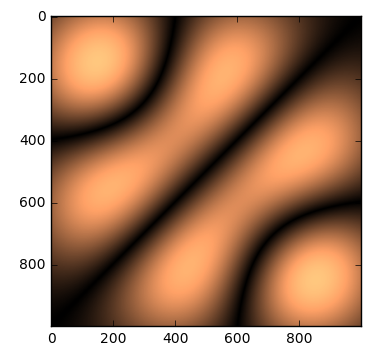

[3, 3]


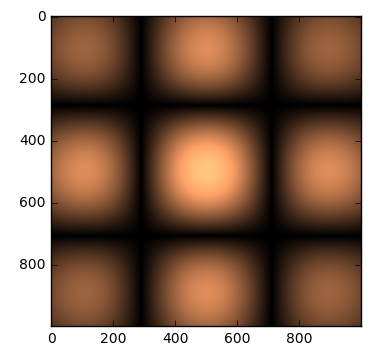

[[2, 4], [4, 2]]


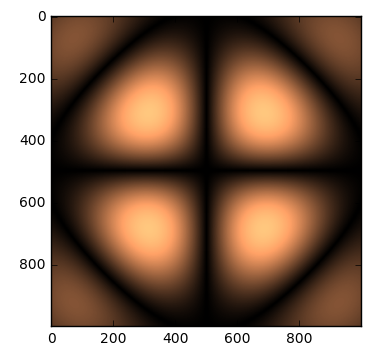

[[1, 5], [5, 1]]


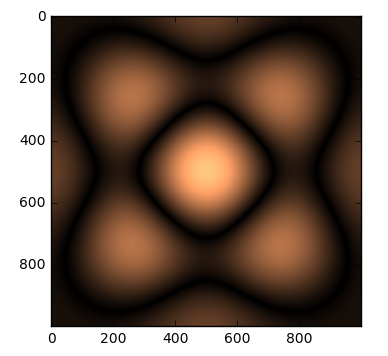

[[3, 5], [5, 3]]


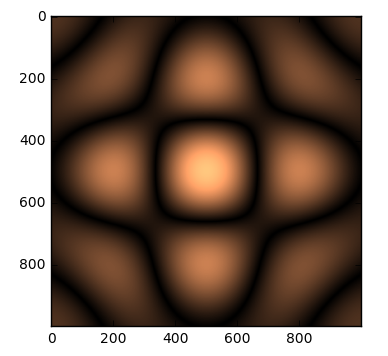

In [69]:
for mode in eigenmodes:
    if type(mode[0]) == type(1):
        #Not degenerate!
        print(mode)
        plt.imshow(np.abs(np.dot(eigenmode_function[mode[0]-1](x_domain_full)[:, None],
                   eigenmode_function[mode[1]-1](y_domain_full)[None])), cmap='copper')
        plt.show()
    else:
        #Degenerate!
        print(mode)
        plt.imshow(np.abs(np.dot(eigenmode_function[mode[0][0]-1](x_domain_full)[:, None],
                   eigenmode_function[mode[0][1]-1](y_domain_full)[None]) + \
                  np.dot(eigenmode_function[mode[1][0]-1](x_domain_full)[:, None],
                   eigenmode_function[mode[1][1]-1](y_domain_full)[None])), cmap='copper')
        plt.show()

data/13_102.5_104.5_0.1.npy [1, 1]


NameError: name 'f5' is not defined

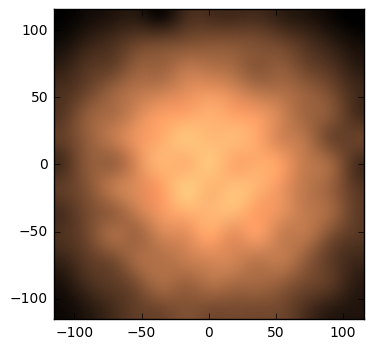

In [10]:
for i, data_filename in enumerate(good_maps):
    amplitude = np.load(data_filename)
    summed_z = np.average(amplitude, 2)
    print(data_filename, eigenmodes[i]),
    
    plt.imshow(summed_z, cmap='copper', interpolation='lanczos',
              extent=tuple(np.array([-7, 7, -7, 7])*mm_per_gridpoint))
    theoretical_mode_full = np.abs(five_one_theory_amplitude_full+one_five_theory_amplitude_full)
    plt.show()